In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
titanic = sns.load_dataset('titanic')

duplicated_features = ['class', 'who', 'embark_town', 'alive', 'adult_male', 'pclass']
titanic = titanic.drop(columns=duplicated_features)

titanic

,survived,sex,age,sibsp,parch,fare,embarked,deck,alone
0,0,male,22.0,1,0,7.2500,S,NaN,False
1,1,female,38.0,1,0,71.2833,C,C,False
2,1,female,26.0,0,0,7.9250,S,NaN,True
3,1,female,35.0,1,0,53.1000,S,C,False
4,0,male,35.0,0,0,8.0500,S,NaN,True
...,...,...,...,...,...,...,...,...,...
886,0,male,27.0,0,0,13.0000,S,NaN,True
887,1,female,19.0,0,0,30.0000,S,B,True
888,0,female,NaN,1,2,23.4500,S,NaN,False
889,1,male,26.0,0,0,30.0000,C,C,True


In [11]:
titanic.isna().sum(axis=0)

survived      0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
deck        688
alone         0
dtype: int64

In [12]:
# Обработка пропусков

## Embarked - заменяем пропуски модой
titanic['embarked'] = titanic['embarked'].fillna(titanic.embarked.mode().iloc[0])

## Age - замена средним
# titanic['age'] = titanic['age'].fillna(titanic.age.mean())
titanic = titanic.dropna(subset=['age'])

## Deck - замена специальным значением
titanic.deck = titanic.deck.astype('str')
titanic.loc[titanic.deck.eq('nan'), 'deck'] = 'U'

/home/dmitry/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/dmitry/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
# Кодирование категориальных признаков

## sex - у нас бинарный, там всё просто
sex_map = {sex: i for i, sex in enumerate(titanic.sex.unique())}
titanic.sex = titanic.sex.map(sex_map)

## embarked/deck - похитрее
features = ['embarked', 'deck']

for feature in features:
    for cat in titanic[feature].unique():
        col_name = f'{feature}_{cat}'
        values = titanic[feature].eq(cat)
        
        titanic[col_name] = values.astype(int)
    
    titanic = titanic.drop(columns=[feature])
    
    
titanic.head()

<ipython-input-13-68a6a065dd24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic[col_name] = values.astype(int)


,survived,sex,age,sibsp,parch,fare,alone,embarked_S,embarked_C,embarked_Q,deck_U,deck_C,deck_E,deck_G,deck_D,deck_A,deck_B,deck_F
0,0,0,22.0,1,0,7.2500,False,1,0,0,1,0,0,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,False,0,1,0,0,1,0,0,0,0,0,0
2,1,1,26.0,0,0,7.9250,True,1,0,0,1,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,False,1,0,0,0,1,0,0,0,0,0,0
4,0,0,35.0,0,0,8.0500,True,1,0,0,1,0,0,0,0,0,0,0


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
target_feature = 'survived'
X = titanic.drop(columns=target_feature)
y = titanic[target_feature]

val_percentage = 0.2
# np.random.seed(1)

rf_acc = []
tree_acc = []

for i in range(25):
    train_rows = np.random.rand(y.size) > val_percentage

    X_train = X[train_rows]
    X_val = X[~train_rows]

    y_train = y[train_rows]
    y_val = y[~train_rows]

    rmodel = RandomForestClassifier()
    rmodel.fit(X_train, y_train)

    rf_predict = rmodel.predict(X_val)
    rf_accuracy = (rf_predict == y_val).mean() *  100 

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    tree_predict = model.predict(X_val)
    tree_accuracy = (tree_predict == y_val).mean() *  100

    rf_acc.append(rf_accuracy)
    tree_acc.append(tree_accuracy)
    
tree_accuracy = np.mean(tree_acc)
rf_accuracy = np.mean(rf_acc)

print(f'Tree accuracy: {tree_accuracy:.2f}%')
print(f'Random Forest accuracy: {rf_accuracy:.2f}%')

Tree accuracy: 74.20%
Random Forest accuracy: 77.70%


# Бинарные метрики

In [146]:
rf_pred = rf_predict
ans = y_val.values

rf_acc = (rf_pred == ans).mean()

rnd_pred = np.random.randint(0, 2, ans.size)
rnd_acc = (rnd_pred == ans).mean()

skynet_pred = np.zeros_like(ans)
skynet_acc = (skynet_pred == ans).mean()

pacific_pred = np.ones_like(ans)

# print(rf_acc)
# print(rnd_acc)
# print(skynet_acc)

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(ans, rf_pred)
# [[tn, fp], [fn, tp]] = matrix
tn, fp, fn, tp = matrix.ravel()

recall = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

F = (recall * precision) / (recall + precision)

recall, specificity, precision, F

(0.7169811320754716,
 0.8765432098765432,
 0.7916666666666666,
 0.37623762376237624)

# Предсказание вероятности


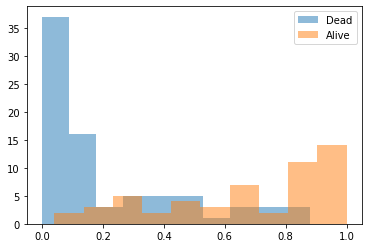

In [183]:
rf_proba = rmodel.predict_proba(X_val)[:, 1]

plt.hist(rf_proba[y_val == 0], label='Dead', alpha=0.5)
plt.hist(rf_proba[y_val == 1], label='Alive', alpha=0.5)
plt.legend()

<ipython-input-173-26101f3db574>:11: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


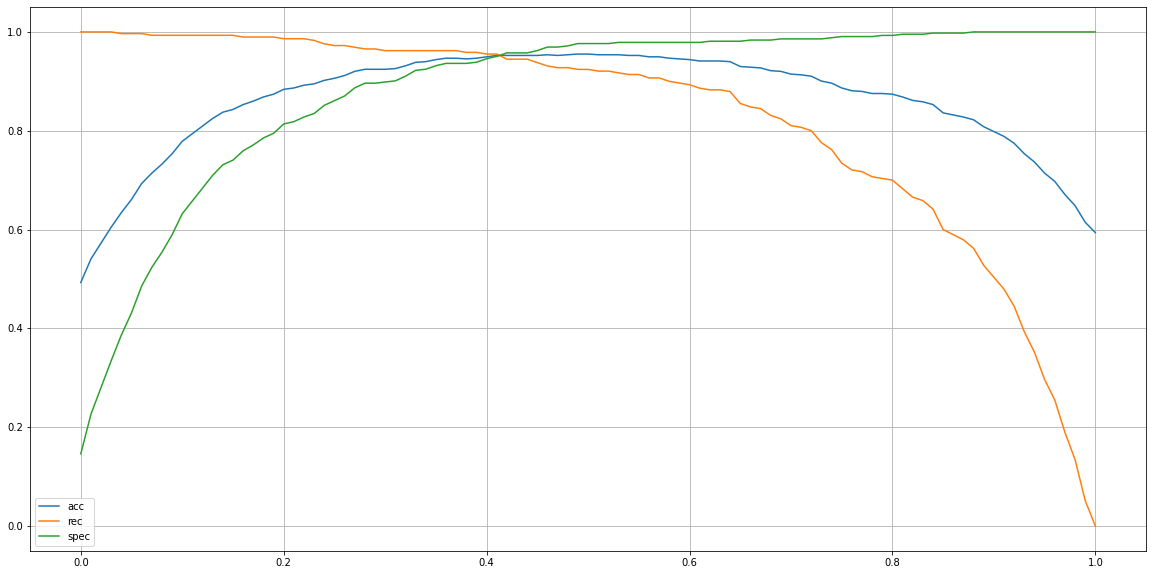

In [173]:
acc, rec, prec, spec = [], [], [], []
thresholds = np.arange(0, 1.01, 0.01)

for threshold in thresholds: 
    bin_pred = rf_proba > threshold

    tn, fp, fn, tp = confusion_matrix(y, bin_pred).ravel()

    accuracy = (bin_pred == y).mean()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)

    acc.append(accuracy)
    rec.append(recall)
    spec.append(specificity)
    prec.append(precision)
    

plt.figure(figsize=(20, 10))
plt.plot(thresholds, acc, label='acc')
plt.plot(thresholds, rec, label='rec')
plt.plot(thresholds, spec, label='spec')
# plt.plot(thresholds, prec, label='prec')

plt.grid()
plt.legend();

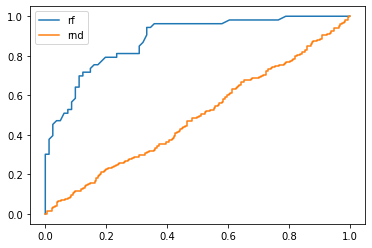

In [184]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

rnd_proba = np.random.rand(y.size)

fpr, tpr, thresh = roc_curve(y_val, rf_proba)
plt.plot(fpr, tpr, label='rf')

fpr, tpr, thresh = roc_curve(y, rnd_proba)
plt.plot(fpr, tpr, label='rnd')

plt.legend()
# plt.plot(thresholds)

In [186]:
roc_auc_score(y_val, rf_proba)

0.8819007686932214